In [1]:
import numpy as np
import openqcs as o
import openqcs.iterativ as it
import openqcs.spinchain as sp
import openqcs.tools as t

import matplotlib.pyplot as plt

#########################################################
valid time steps:  56
[0, 38]


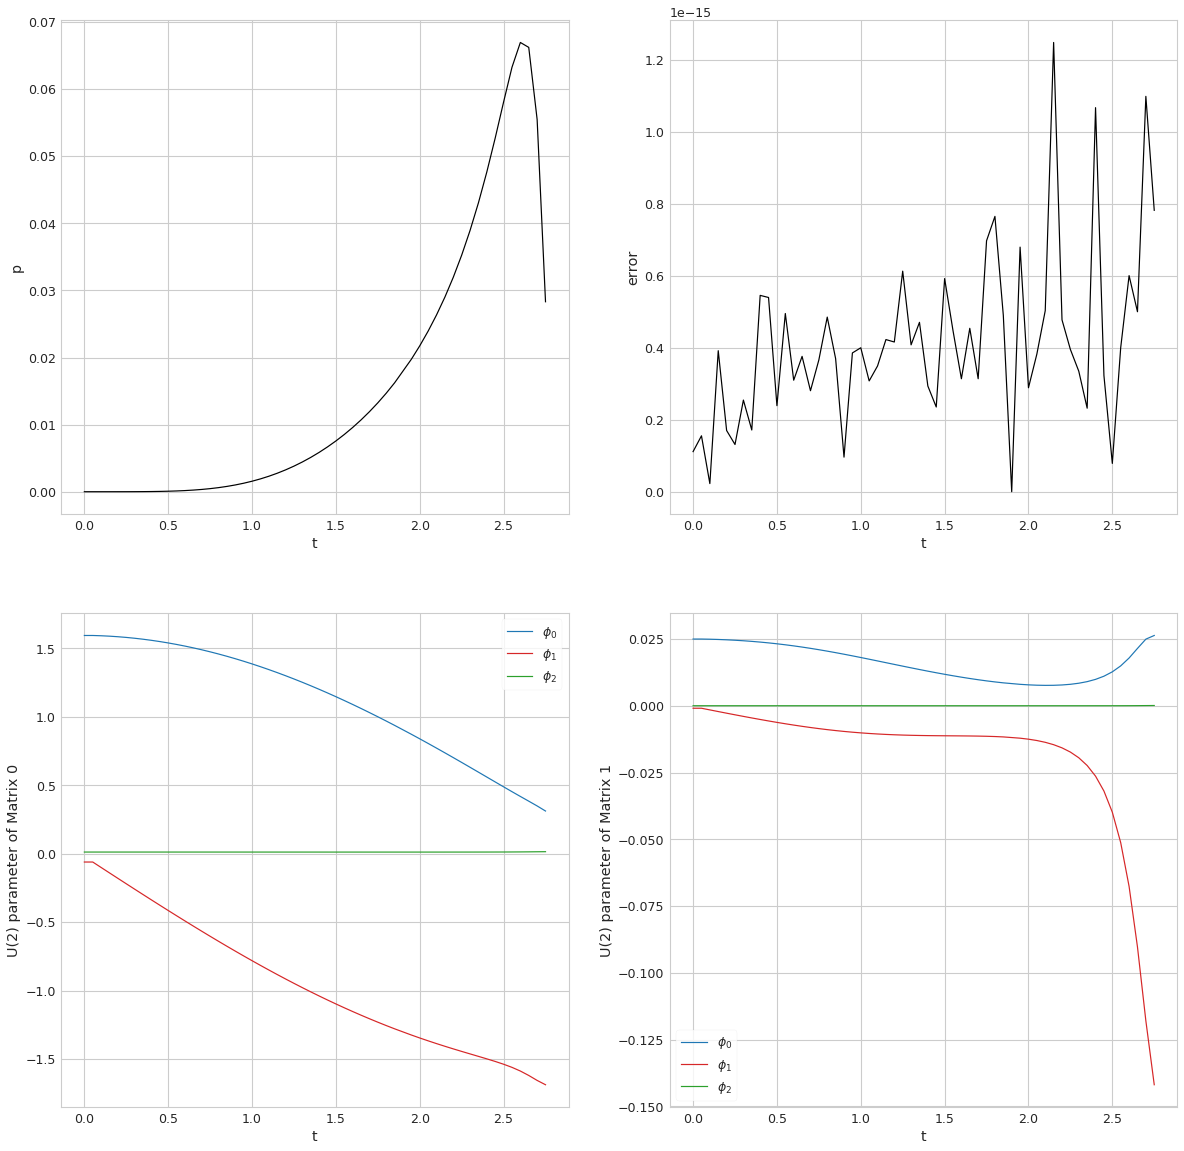

In [2]:
def get_data(a, b, dt, plotting=False):
    H = sp.H_(a,b)
    T = sp.T_(H,dt)
    
    data, err, n_t = it.iterative_evolution(T)
    
    if plotting:
        it.plot_param(data, err, n_t, dt)
    
    return data, n_t

data, n_t = get_data(0.5, 0.5, 0.05, plotting=True)

## Note for Bug Fixing:

For $dt = 0.1$ the pseudo Kraus operator are not special, i.e. $\det{E_i} \neq 1$. Hence the algorithm does not work for these ranges

#########################################################
valid time steps:  56
[0, 38]
step 0 of 56
step 1 of 56


/home/andreas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: ComplexWarning: Casting complex values to real discards the imaginary part


step 2 of 56
step 3 of 56
step 4 of 56
step 5 of 56
step 6 of 56
step 7 of 56
step 8 of 56
step 9 of 56
step 10 of 56
step 11 of 56
step 12 of 56
step 13 of 56
step 14 of 56
step 15 of 56
step 16 of 56
step 17 of 56
step 18 of 56
step 19 of 56
step 20 of 56
step 21 of 56
step 22 of 56
step 23 of 56
step 24 of 56
step 25 of 56
step 26 of 56
step 27 of 56
step 28 of 56
step 29 of 56
step 30 of 56
step 31 of 56
step 32 of 56
step 33 of 56
step 34 of 56
step 35 of 56
step 36 of 56
step 37 of 56
step 38 of 56
step 39 of 56
step 40 of 56
step 41 of 56
step 42 of 56
step 43 of 56
step 44 of 56
step 45 of 56
step 46 of 56
step 47 of 56
step 48 of 56
step 49 of 56
step 50 of 56
step 51 of 56
step 52 of 56
step 53 of 56
step 54 of 56
step 55 of 56


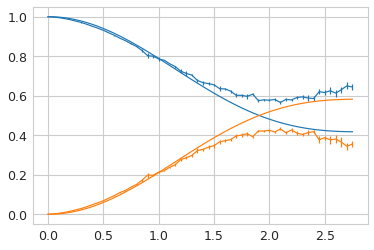

In [26]:
import pyqcs
import openqcs.qcirc as qu
import openqcs.statistic as st

def get_data(a, b, dt, plotting=False):
    H = sp.H_(a,b)
    T = sp.T_(H,dt)
    
    data, err, n_t = it.iterative_evolution(T)
    
    if plotting:
        it.plot_param(data, err, n_t, dt)
    
    return data, n_t

def QuantumEvolution(data, n_sample, iSt=pyqcs.State.new_zero_state(1), n_measure=1000, log=False):

    probs = data[:,0]

    circs = np.ndarray((probs.shape[0],2), dtype=pyqcs.AnonymousCompoundGateCircuit)

    for i, d in enumerate(data):
        c1 = qu.su2_to_circuit(0, d[1:4])
        c2 = qu.su2_to_circuit(0, d[4:])
        circs[i,:] = [c1, c2]
        
        
    output = np.zeros((n_sample, 2), dtype=float)
    
    paths = []
    
    for i in range(n_sample):
        
        evolute_gates = np.ndarray(probs.shape[0], dtype=pyqcs.AnonymousCompoundGateCircuit)
        path=""
        for k, p in enumerate(probs):
            
            q = np.random.rand()
            if q < p:
                evolute_gates[k] = circs[k,0]
                path+="0"
            else:
                evolute_gates[k] = circs[k,1]
                path+="1"
        
        U_gate = pyqcs.list_to_circuit(evolute_gates)
        
        psi = U_gate*iSt
        
        res = pyqcs.sample(psi, 1, n_measure)
        paths.append(path)
        
        for key, val in res.items():
            output[i,key] = float(val)/n_measure
    
    paths = np.array(paths)
    
    means = np.zeros(10, dtype=np.double)
    for i in range(10):
        tmp = np.random.choice(output[:,0], size=data.shape[0], replace=True)
        means[i] = np.mean(tmp)
    mean0, err0 = st.bootstrap(output[:,0])
    mean1, err1 = st.bootstrap(output[:,1])
    if log:
        return mean0, err0, mean1, err1, paths
    else:
        return mean0, err0, mean1, err1

def ClassicalEvolution(idx, T, rho0):
    
    rho = o.rho_sys_(T**idx, rho0)
    
    return rho[0,0], rho[1,1]
        
    

def main(saving=False, plotting=True):
    a = 0.5
    b = 0.5
    dt = 0.05
    
    n_sample = 100
    
    data, n_t = get_data(a,b,dt)
    
    t_data = np.arange(n_t) * dt
    qc_prob = np.zeros((n_t, 2,2), dtype=np.double)
    cl_prob = np.zeros((n_t, 2), dtype=np.double)
    
    H = sp.H_(a,b)
    T = sp.T_(H,dt)
    
    iSt = pyqcs.State.new_zero_state(1)
    rho0 = np.matrix([[1,0],[0,0]])
    for i in range(n_t):
        print("step {} of {}".format(i, n_t), flush=True)
        m0, e0, m1, e1 = QuantumEvolution(data[:i+1], n_sample, iSt=iSt)
        qc_prob[i,:,:] = [[m0, e0], [m1, e1]]
        
        r0, r1 = ClassicalEvolution(i, T, rho0)
        cl_prob[i,:] = [r0, r1]
        
    if plotting:
        
        colors = ["tab:blue", "tab:orange"]
        
        plt.figure()
        
        
        for i in range(2):
            plt.plot(t_data, cl_prob[:,i], color=colors[i], label="|%d>"%i)
            plt.errorbar(t_data, qc_prob[:,i,0], yerr=qc_prob[:,i,1], 
                        color=colors[i])
            
        plt.show()
        
main()
        
        
    


In [23]:
import time


def main():
    a = 0.5
    b = 0.5
    dt = 0.05

    n_samples = np.logspace(2, 3, 5, dtype=int)


    data, n_t = get_data(a,b,dt)


    H = sp.H_(a,b)
    T = sp.T_(H,dt)

    iSt = pyqcs.State.new_zero_state(1)
    rho0 = np.matrix([[1,0],[0,0]])

    times = np.zeros(n_samples.shape[0], dtype=np.double)
    probs = np.zeros((n_samples.shape[0], 2, 2), dtype=np.double)

    for i, n in enumerate(n_samples):
        print("n_sample = {}".format(n), flush=True)
        t_begin = time.time()
        m0, e0, m1, e1, paths = QuantumEvolution(data, n, iSt=iSt, log=True)
        probs[i,:,:] = [[m0, e0], [m1, e1]]
        t_end = time.time()
        times[i] = t_end - t_begin
        print("exicution time: ", t_end - t_begin)




    r0, r1 = ClassicalEvolution(i, T, rho0)


#########################################################
valid time steps:  56
[0, 38]
n_sample = 100
exicution time:  2.730605363845825
n_sample = 177
exicution time:  4.733362913131714
n_sample = 316
exicution time:  8.492499828338623
n_sample = 562
exicution time:  17.97433066368103
n_sample = 1000
exicution time:  34.61464166641235


[0.630754   0.65566893 0.63350285 0.6371968  0.6403483 ]


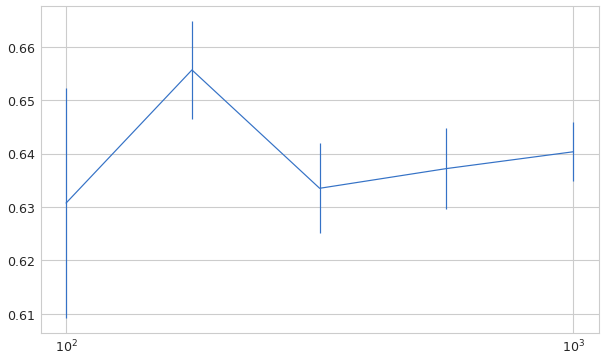

In [28]:
print(probs[:,0,0])

plt.figure(figsize=(10, 6))
plt.errorbar(n_samples, probs[:,0,0], yerr=probs[:,0,1])
plt.xscale("log")
plt.show()

In [27]:
m0, e0, m1, e1, paths = QuantumEvolution(data, 1000, iSt=iSt, log=True)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 999.]),
 array([7.20400019e+16, 7.20417611e+16, 7.20435203e+16, 7.20452795e+16,
        7.20470387e+16, 7.20487979e+16, 7.20505572e+16, 7.20523164e+16,
        7.20540756e+16, 7.20558348e+16, 7.20575940e+16]),
 <a list of 10 Patch objects>)

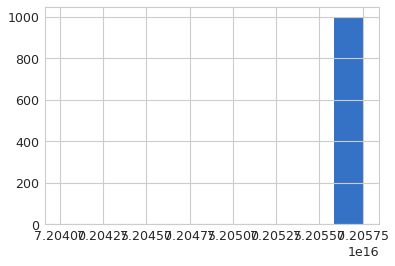

In [36]:
values = [int(p, 2) for p in paths]